In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets
from tqdm import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import math
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()

# Model Design


Some tips you can use in the model design:

*   Convolution
*   Linear
*   Pooling
*   Batch normalization
*   ReLU
*   Dropout




In [12]:
# Create an instance of the DNN model
from mobilenet_model.mobilenet_model import Our_MobileNetV3,BN_fold_Our_MobileNetV3
from mobilenet_model.mobilenet_model import SELayer,h_swish,h_sigmoid
from mobilenet_model.mobilenet_model import _make_divisible

net =  Our_MobileNetV3().cuda()  # Move the model to GPU if available
print(net)


Our_MobileNetV3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1): MobileNetV3_block(
    (pw1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hs1): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (dw1): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=8, bias=False)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hs2): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (se1): SELayer(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=8, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=8, bias=False)
        (3): ReLU(inplace=True)
      )
    )
    (pw2): Conv2d(8, 16, kernel_si

# Caculating the number of the parameter and the MACs of the model

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
grad_para = count_parameters(net)
# print(f'Total params: {grad_para / 1e6}M')
summary(net,(1,28,28))

#Compute MACs
from thop import profile
input1 = torch.randn(1,1,28,28).cuda()
MACs, params = profile(net, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2            [-1, 8, 28, 28]              64
       BatchNorm2d-3            [-1, 8, 28, 28]              16
             ReLU6-4            [-1, 8, 28, 28]               0
         h_sigmoid-5            [-1, 8, 28, 28]               0
           h_swish-6            [-1, 8, 28, 28]               0
            Conv2d-7            [-1, 8, 14, 14]              72
       BatchNorm2d-8            [-1, 8, 14, 14]              16
             ReLU6-9            [-1, 8, 14, 14]               0
        h_sigmoid-10            [-1, 8, 14, 14]               0
          h_swish-11            [-1, 8, 14, 14]               0
AdaptiveAvgPool2d-12              [-1, 8, 1, 1]               0
           Linear-13                    [-1, 8]              64
             ReLU-14                   

# Configuration

In [14]:
### TODO : You can modify the configuration for model training ###

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = optim.Adam(net.parameters(), lr=0.001)

# The number of batch size.
batch_size = 512

# If no improvement in 'patience' epochs, early stop.
patience  = 10

# The number of training epochs
n_epoch = 100

_exp_name = "N26122246_minist"

# Dataloader

In [15]:


# Select training_set and testing_set (dataset : FashionMNIST )
train_data = datasets.FashionMNIST("data",train= True, download=True,   transform = transforms.ToTensor())

test_data = datasets.FashionMNIST("data",  train= False, download=True, transform = transforms.ToTensor())

# # Number of subprocesses to use for data loading
# num_workers = 0

# Percentage of training set to use as validation
n_valid = 0.2

# Get indices for training_set and validation_set
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)

split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


In [16]:
# Training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  sampler = train_sampler , num_workers=2)

# Validation data
validloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, sampler = valid_sampler, num_workers = 2)

# Test data
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  num_workers=2)



# Model Training

In [17]:
train_loss_epoch = []
val_loss_epoch = []

best_acc = 0
epoch_counter = 0

for epoch in range(n_epoch):  # loop over the dataset multiple times


    running_loss = 0.0
    epoch_counter += 1

    ################## Training ##################
    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_loss_epoch.append(train_loss)


    # Print the information.
    print('========================================================================================================')
    print(f"[ Train | {epoch + 1:03d}/{n_epoch:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    ################## Validition ##################
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for data in tqdm(validloader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = data
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = net(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())
        #break

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    val_loss_epoch.append(valid_loss)


    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epoch:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


     # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch + 1:03d}, saving model")
        torch.save(net.state_dict(), './Mobilenet_ckpt/Mobilenet_origin_trained.ckpt') # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

print('Finished Training')

[ Train | 001/100 ] loss = 2.30232, acc = 0.10573


100%|██████████| 24/24 [00:02<00:00,  8.56it/s]


[ Valid | 001/100 ] loss = 2.29842, acc = 0.10538
Best model found at epoch 001, saving model
[ Train | 002/100 ] loss = 2.29250, acc = 0.10651


100%|██████████| 24/24 [00:02<00:00,  8.66it/s]


[ Valid | 002/100 ] loss = 2.29317, acc = 0.10796
Best model found at epoch 002, saving model
[ Train | 003/100 ] loss = 2.29371, acc = 0.10736


100%|██████████| 24/24 [00:02<00:00,  8.52it/s]


[ Valid | 003/100 ] loss = 2.29158, acc = 0.10479
[ Train | 004/100 ] loss = 2.28925, acc = 0.10681


100%|██████████| 24/24 [00:02<00:00,  8.90it/s]


[ Valid | 004/100 ] loss = 2.28862, acc = 0.10519
[ Train | 005/100 ] loss = 2.28547, acc = 0.11016


100%|██████████| 24/24 [00:02<00:00,  8.29it/s]


[ Valid | 005/100 ] loss = 2.28414, acc = 0.11137
Best model found at epoch 005, saving model
[ Train | 006/100 ] loss = 2.27551, acc = 0.11554


100%|██████████| 24/24 [00:02<00:00,  8.50it/s]


[ Valid | 006/100 ] loss = 2.27315, acc = 0.12185
Best model found at epoch 006, saving model
[ Train | 007/100 ] loss = 2.25868, acc = 0.12461


100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


[ Valid | 007/100 ] loss = 2.25235, acc = 0.12712
Best model found at epoch 007, saving model
[ Train | 008/100 ] loss = 2.21750, acc = 0.13790


100%|██████████| 24/24 [00:02<00:00,  8.34it/s]


[ Valid | 008/100 ] loss = 2.16838, acc = 0.15442
Best model found at epoch 008, saving model
[ Train | 009/100 ] loss = 2.03971, acc = 0.18677


100%|██████████| 24/24 [00:02<00:00,  8.98it/s]


[ Valid | 009/100 ] loss = 1.90359, acc = 0.24098
Best model found at epoch 009, saving model
[ Train | 010/100 ] loss = 1.67085, acc = 0.33252


100%|██████████| 24/24 [00:02<00:00,  9.28it/s]


[ Valid | 010/100 ] loss = 1.42856, acc = 0.44101
Best model found at epoch 010, saving model
[ Train | 011/100 ] loss = 1.32666, acc = 0.47592


100%|██████████| 24/24 [00:02<00:00,  9.20it/s]


[ Valid | 011/100 ] loss = 1.26770, acc = 0.50267
Best model found at epoch 011, saving model
[ Train | 012/100 ] loss = 1.20116, acc = 0.52567


100%|██████████| 24/24 [00:02<00:00,  9.27it/s]


[ Valid | 012/100 ] loss = 1.15216, acc = 0.54422
Best model found at epoch 012, saving model
[ Train | 013/100 ] loss = 1.06895, acc = 0.57705


100%|██████████| 24/24 [00:02<00:00,  9.25it/s]


[ Valid | 013/100 ] loss = 1.06093, acc = 0.57444
Best model found at epoch 013, saving model
[ Train | 014/100 ] loss = 0.96437, acc = 0.61668


100%|██████████| 24/24 [00:02<00:00,  9.26it/s]


[ Valid | 014/100 ] loss = 0.92288, acc = 0.64421
Best model found at epoch 014, saving model
[ Train | 015/100 ] loss = 0.84142, acc = 0.67537


100%|██████████| 24/24 [00:02<00:00,  9.11it/s]


[ Valid | 015/100 ] loss = 0.79115, acc = 0.69720
Best model found at epoch 015, saving model
[ Train | 016/100 ] loss = 0.72683, acc = 0.72508


100%|██████████| 24/24 [00:02<00:00,  9.47it/s]


[ Valid | 016/100 ] loss = 0.70621, acc = 0.73683
Best model found at epoch 016, saving model
[ Train | 017/100 ] loss = 0.66027, acc = 0.75255


100%|██████████| 24/24 [00:02<00:00,  9.09it/s]


[ Valid | 017/100 ] loss = 0.65545, acc = 0.75686
Best model found at epoch 017, saving model
[ Train | 018/100 ] loss = 0.62390, acc = 0.76560


100%|██████████| 24/24 [00:02<00:00,  9.47it/s]


[ Valid | 018/100 ] loss = 0.64738, acc = 0.75559
[ Train | 019/100 ] loss = 0.59429, acc = 0.77571


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


[ Valid | 019/100 ] loss = 0.61085, acc = 0.77300
Best model found at epoch 019, saving model
[ Train | 020/100 ] loss = 0.56224, acc = 0.79013


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


[ Valid | 020/100 ] loss = 0.57442, acc = 0.78231
Best model found at epoch 020, saving model
[ Train | 021/100 ] loss = 0.53905, acc = 0.80010


100%|██████████| 24/24 [00:02<00:00,  9.09it/s]


[ Valid | 021/100 ] loss = 0.54890, acc = 0.79883
Best model found at epoch 021, saving model
[ Train | 022/100 ] loss = 0.51919, acc = 0.80926


100%|██████████| 24/24 [00:02<00:00,  9.32it/s]


[ Valid | 022/100 ] loss = 0.53378, acc = 0.80586
Best model found at epoch 022, saving model
[ Train | 023/100 ] loss = 0.49473, acc = 0.81788


100%|██████████| 24/24 [00:02<00:00,  9.34it/s]


[ Valid | 023/100 ] loss = 0.51035, acc = 0.81029
Best model found at epoch 023, saving model
[ Train | 024/100 ] loss = 0.47835, acc = 0.82472


100%|██████████| 24/24 [00:02<00:00,  9.31it/s]


[ Valid | 024/100 ] loss = 0.49142, acc = 0.81813
Best model found at epoch 024, saving model
[ Train | 025/100 ] loss = 0.46027, acc = 0.83172


100%|██████████| 24/24 [00:02<00:00,  9.53it/s]


[ Valid | 025/100 ] loss = 0.48534, acc = 0.82268
Best model found at epoch 025, saving model
[ Train | 026/100 ] loss = 0.44394, acc = 0.83736


100%|██████████| 24/24 [00:02<00:00,  9.47it/s]


[ Valid | 026/100 ] loss = 0.47192, acc = 0.82524
Best model found at epoch 026, saving model
[ Train | 027/100 ] loss = 0.42869, acc = 0.84361


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


[ Valid | 027/100 ] loss = 0.45729, acc = 0.83421
Best model found at epoch 027, saving model
[ Train | 028/100 ] loss = 0.41490, acc = 0.84842


100%|██████████| 24/24 [00:02<00:00,  9.51it/s]


[ Valid | 028/100 ] loss = 0.44032, acc = 0.84019
Best model found at epoch 028, saving model
[ Train | 029/100 ] loss = 0.40417, acc = 0.85157


100%|██████████| 24/24 [00:02<00:00,  9.55it/s]


[ Valid | 029/100 ] loss = 0.43219, acc = 0.84438
Best model found at epoch 029, saving model
[ Train | 030/100 ] loss = 0.39322, acc = 0.85419


100%|██████████| 24/24 [00:02<00:00,  9.73it/s]


[ Valid | 030/100 ] loss = 0.42943, acc = 0.84309
[ Train | 031/100 ] loss = 0.38406, acc = 0.85911


100%|██████████| 24/24 [00:02<00:00,  9.38it/s]


[ Valid | 031/100 ] loss = 0.41540, acc = 0.84878
Best model found at epoch 031, saving model
[ Train | 032/100 ] loss = 0.37805, acc = 0.86145


100%|██████████| 24/24 [00:02<00:00,  9.66it/s]


[ Valid | 032/100 ] loss = 0.42199, acc = 0.84666
[ Train | 033/100 ] loss = 0.36726, acc = 0.86386


100%|██████████| 24/24 [00:02<00:00,  9.59it/s]


[ Valid | 033/100 ] loss = 0.41865, acc = 0.85011
Best model found at epoch 033, saving model
[ Train | 034/100 ] loss = 0.36370, acc = 0.86687


100%|██████████| 24/24 [00:02<00:00,  9.54it/s]


[ Valid | 034/100 ] loss = 0.40648, acc = 0.85234
Best model found at epoch 034, saving model
[ Train | 035/100 ] loss = 0.35814, acc = 0.86822


100%|██████████| 24/24 [00:02<00:00,  9.60it/s]


[ Valid | 035/100 ] loss = 0.40053, acc = 0.85595
Best model found at epoch 035, saving model
[ Train | 036/100 ] loss = 0.35098, acc = 0.87005


100%|██████████| 24/24 [00:02<00:00,  9.53it/s]


[ Valid | 036/100 ] loss = 0.39751, acc = 0.85572
[ Train | 037/100 ] loss = 0.34264, acc = 0.87283


100%|██████████| 24/24 [00:02<00:00,  9.50it/s]


[ Valid | 037/100 ] loss = 0.39722, acc = 0.85439
[ Train | 038/100 ] loss = 0.33701, acc = 0.87508


100%|██████████| 24/24 [00:02<00:00,  9.36it/s]


[ Valid | 038/100 ] loss = 0.39675, acc = 0.85783
Best model found at epoch 038, saving model
[ Train | 039/100 ] loss = 0.33264, acc = 0.87684


100%|██████████| 24/24 [00:02<00:00,  9.49it/s]


[ Valid | 039/100 ] loss = 0.38762, acc = 0.85940
Best model found at epoch 039, saving model
[ Train | 040/100 ] loss = 0.32896, acc = 0.87706


100%|██████████| 24/24 [00:02<00:00,  9.56it/s]


[ Valid | 040/100 ] loss = 0.37694, acc = 0.86579
Best model found at epoch 040, saving model
[ Train | 041/100 ] loss = 0.32054, acc = 0.88164


100%|██████████| 24/24 [00:02<00:00,  9.52it/s]


[ Valid | 041/100 ] loss = 0.38880, acc = 0.85919
[ Train | 042/100 ] loss = 0.31564, acc = 0.88191


100%|██████████| 24/24 [00:02<00:00,  9.45it/s]


[ Valid | 042/100 ] loss = 0.37505, acc = 0.86223
[ Train | 043/100 ] loss = 0.31069, acc = 0.88522


100%|██████████| 24/24 [00:02<00:00,  9.24it/s]


[ Valid | 043/100 ] loss = 0.37444, acc = 0.86394
[ Train | 044/100 ] loss = 0.30529, acc = 0.88608


100%|██████████| 24/24 [00:02<00:00,  9.40it/s]


[ Valid | 044/100 ] loss = 0.37203, acc = 0.86745
Best model found at epoch 044, saving model
[ Train | 045/100 ] loss = 0.30227, acc = 0.88734


100%|██████████| 24/24 [00:02<00:00,  9.48it/s]


[ Valid | 045/100 ] loss = 0.36257, acc = 0.86997
Best model found at epoch 045, saving model
[ Train | 046/100 ] loss = 0.29988, acc = 0.88743


100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


[ Valid | 046/100 ] loss = 0.37277, acc = 0.86557
[ Train | 047/100 ] loss = 0.29653, acc = 0.88975


100%|██████████| 24/24 [00:02<00:00,  9.22it/s]


[ Valid | 047/100 ] loss = 0.36059, acc = 0.87106
Best model found at epoch 047, saving model
[ Train | 048/100 ] loss = 0.28756, acc = 0.89175


100%|██████████| 24/24 [00:02<00:00,  9.48it/s]


[ Valid | 048/100 ] loss = 0.36452, acc = 0.86808
[ Train | 049/100 ] loss = 0.28127, acc = 0.89470


100%|██████████| 24/24 [00:02<00:00,  8.90it/s]


[ Valid | 049/100 ] loss = 0.36072, acc = 0.86934
[ Train | 050/100 ] loss = 0.28372, acc = 0.89314


100%|██████████| 24/24 [00:02<00:00,  9.06it/s]


[ Valid | 050/100 ] loss = 0.37173, acc = 0.86813
[ Train | 051/100 ] loss = 0.27963, acc = 0.89522


100%|██████████| 24/24 [00:03<00:00,  7.82it/s]


[ Valid | 051/100 ] loss = 0.37358, acc = 0.86907
[ Train | 052/100 ] loss = 0.27418, acc = 0.89626


100%|██████████| 24/24 [00:02<00:00,  9.07it/s]


[ Valid | 052/100 ] loss = 0.36319, acc = 0.87217
Best model found at epoch 052, saving model
[ Train | 053/100 ] loss = 0.26956, acc = 0.89828


100%|██████████| 24/24 [00:02<00:00,  8.97it/s]


[ Valid | 053/100 ] loss = 0.36850, acc = 0.86992
[ Train | 054/100 ] loss = 0.26752, acc = 0.89930


100%|██████████| 24/24 [00:02<00:00,  9.13it/s]


[ Valid | 054/100 ] loss = 0.35595, acc = 0.87526
Best model found at epoch 054, saving model
[ Train | 055/100 ] loss = 0.26253, acc = 0.90153


100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


[ Valid | 055/100 ] loss = 0.35522, acc = 0.87431
[ Train | 056/100 ] loss = 0.26095, acc = 0.90045


100%|██████████| 24/24 [00:02<00:00,  9.10it/s]


[ Valid | 056/100 ] loss = 0.35936, acc = 0.87340
[ Train | 057/100 ] loss = 0.25666, acc = 0.90277


100%|██████████| 24/24 [00:02<00:00,  8.87it/s]


[ Valid | 057/100 ] loss = 0.36553, acc = 0.87123
[ Train | 058/100 ] loss = 0.25693, acc = 0.90316


100%|██████████| 24/24 [00:02<00:00,  9.05it/s]


[ Valid | 058/100 ] loss = 0.35446, acc = 0.87619
Best model found at epoch 058, saving model
[ Train | 059/100 ] loss = 0.25067, acc = 0.90605


100%|██████████| 24/24 [00:03<00:00,  7.43it/s]


[ Valid | 059/100 ] loss = 0.35102, acc = 0.87627
Best model found at epoch 059, saving model
[ Train | 060/100 ] loss = 0.24698, acc = 0.90689


100%|██████████| 24/24 [00:02<00:00,  9.06it/s]


[ Valid | 060/100 ] loss = 0.36813, acc = 0.87337
[ Train | 061/100 ] loss = 0.24321, acc = 0.90788


100%|██████████| 24/24 [00:02<00:00,  9.11it/s]


[ Valid | 061/100 ] loss = 0.35998, acc = 0.87528
[ Train | 062/100 ] loss = 0.24122, acc = 0.90994


100%|██████████| 24/24 [00:02<00:00,  8.82it/s]


[ Valid | 062/100 ] loss = 0.36338, acc = 0.87238
[ Train | 063/100 ] loss = 0.24029, acc = 0.90920


100%|██████████| 24/24 [00:02<00:00,  8.39it/s]


[ Valid | 063/100 ] loss = 0.35923, acc = 0.87584
[ Train | 064/100 ] loss = 0.23194, acc = 0.91188


100%|██████████| 24/24 [00:02<00:00,  9.04it/s]


[ Valid | 064/100 ] loss = 0.36383, acc = 0.87581
[ Train | 065/100 ] loss = 0.23517, acc = 0.91244


100%|██████████| 24/24 [00:02<00:00,  9.38it/s]


[ Valid | 065/100 ] loss = 0.36026, acc = 0.87367
[ Train | 066/100 ] loss = 0.23049, acc = 0.91283


100%|██████████| 24/24 [00:02<00:00,  9.26it/s]


[ Valid | 066/100 ] loss = 0.36102, acc = 0.87736
Best model found at epoch 066, saving model
[ Train | 067/100 ] loss = 0.22829, acc = 0.91343


100%|██████████| 24/24 [00:02<00:00,  9.23it/s]


[ Valid | 067/100 ] loss = 0.36350, acc = 0.87506
[ Train | 068/100 ] loss = 0.22513, acc = 0.91469


100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


[ Valid | 068/100 ] loss = 0.36772, acc = 0.87635
[ Train | 069/100 ] loss = 0.22257, acc = 0.91560


100%|██████████| 24/24 [00:02<00:00,  9.31it/s]


[ Valid | 069/100 ] loss = 0.35910, acc = 0.87794
Best model found at epoch 069, saving model
[ Train | 070/100 ] loss = 0.21954, acc = 0.91663


100%|██████████| 24/24 [00:02<00:00,  9.00it/s]


[ Valid | 070/100 ] loss = 0.36309, acc = 0.87924
Best model found at epoch 070, saving model
[ Train | 071/100 ] loss = 0.21723, acc = 0.91775


100%|██████████| 24/24 [00:02<00:00,  9.08it/s]


[ Valid | 071/100 ] loss = 0.37141, acc = 0.87330
[ Train | 072/100 ] loss = 0.21167, acc = 0.91962


100%|██████████| 24/24 [00:02<00:00,  9.12it/s]


[ Valid | 072/100 ] loss = 0.37111, acc = 0.87497
[ Train | 073/100 ] loss = 0.21120, acc = 0.91989


100%|██████████| 24/24 [00:02<00:00,  8.62it/s]


[ Valid | 073/100 ] loss = 0.37390, acc = 0.87941
Best model found at epoch 073, saving model
[ Train | 074/100 ] loss = 0.21406, acc = 0.91902


100%|██████████| 24/24 [00:02<00:00,  9.18it/s]


[ Valid | 074/100 ] loss = 0.36369, acc = 0.87780
[ Train | 075/100 ] loss = 0.21121, acc = 0.92086


100%|██████████| 24/24 [00:02<00:00,  9.02it/s]


[ Valid | 075/100 ] loss = 0.35873, acc = 0.87965
Best model found at epoch 075, saving model
[ Train | 076/100 ] loss = 0.20475, acc = 0.92089


100%|██████████| 24/24 [00:02<00:00,  9.21it/s]


[ Valid | 076/100 ] loss = 0.37957, acc = 0.87709
[ Train | 077/100 ] loss = 0.20280, acc = 0.92419


100%|██████████| 24/24 [00:02<00:00,  9.25it/s]


[ Valid | 077/100 ] loss = 0.37944, acc = 0.87592
[ Train | 078/100 ] loss = 0.19798, acc = 0.92495


100%|██████████| 24/24 [00:02<00:00,  8.77it/s]


[ Valid | 078/100 ] loss = 0.37857, acc = 0.87917
[ Train | 079/100 ] loss = 0.19662, acc = 0.92632


100%|██████████| 24/24 [00:02<00:00,  9.32it/s]


[ Valid | 079/100 ] loss = 0.38104, acc = 0.87579
[ Train | 080/100 ] loss = 0.19585, acc = 0.92600


100%|██████████| 24/24 [00:02<00:00,  8.90it/s]


[ Valid | 080/100 ] loss = 0.38696, acc = 0.87709
[ Train | 081/100 ] loss = 0.19529, acc = 0.92653


100%|██████████| 24/24 [00:02<00:00,  9.10it/s]


[ Valid | 081/100 ] loss = 0.36810, acc = 0.88053
Best model found at epoch 081, saving model
[ Train | 082/100 ] loss = 0.18678, acc = 0.92889


100%|██████████| 24/24 [00:03<00:00,  7.99it/s]


[ Valid | 082/100 ] loss = 0.37563, acc = 0.87750
[ Train | 083/100 ] loss = 0.19052, acc = 0.92888


100%|██████████| 24/24 [00:02<00:00,  8.89it/s]


[ Valid | 083/100 ] loss = 0.37980, acc = 0.87892
[ Train | 084/100 ] loss = 0.18674, acc = 0.92853


100%|██████████| 24/24 [00:02<00:00,  8.51it/s]


[ Valid | 084/100 ] loss = 0.37670, acc = 0.87945
[ Train | 085/100 ] loss = 0.18688, acc = 0.92875


100%|██████████| 24/24 [00:02<00:00,  9.24it/s]


[ Valid | 085/100 ] loss = 0.38395, acc = 0.87844
[ Train | 086/100 ] loss = 0.18318, acc = 0.93127


100%|██████████| 24/24 [00:03<00:00,  7.52it/s]


[ Valid | 086/100 ] loss = 0.38981, acc = 0.87992
[ Train | 087/100 ] loss = 0.17934, acc = 0.93189


100%|██████████| 24/24 [00:02<00:00,  8.88it/s]


[ Valid | 087/100 ] loss = 0.39350, acc = 0.87826
[ Train | 088/100 ] loss = 0.17601, acc = 0.93360


100%|██████████| 24/24 [00:02<00:00,  9.10it/s]


[ Valid | 088/100 ] loss = 0.38852, acc = 0.87956
[ Train | 089/100 ] loss = 0.17220, acc = 0.93446


100%|██████████| 24/24 [00:02<00:00,  8.81it/s]


[ Valid | 089/100 ] loss = 0.40395, acc = 0.87565
[ Train | 090/100 ] loss = 0.17162, acc = 0.93514


100%|██████████| 24/24 [00:02<00:00,  9.20it/s]


[ Valid | 090/100 ] loss = 0.39605, acc = 0.88005
[ Train | 091/100 ] loss = 0.17076, acc = 0.93549


100%|██████████| 24/24 [00:02<00:00,  9.02it/s]


[ Valid | 091/100 ] loss = 0.38876, acc = 0.87707
[ Train | 092/100 ] loss = 0.17106, acc = 0.93526


100%|██████████| 24/24 [00:02<00:00,  8.60it/s]

[ Valid | 092/100 ] loss = 0.41306, acc = 0.87427
No improvment 10 consecutive epochs, early stopping
Finished Training


# Model Testing

Your test accuracy  shoud be greater than 85%

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if use_gpu:
            images, labels = images.cuda(),labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 87 %


# Plot the train/val Loss curve

# Plot the train/val loss curve

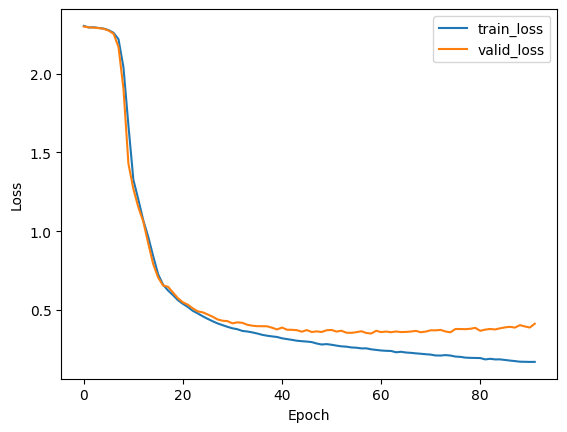

In [19]:
from matplotlib import pyplot as plt
### TODO : Please plot the rain/val loss curve ###


plt.plot(train_loss_epoch, label = 'train_loss')
plt.plot(val_loss_epoch, label = 'valid_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
###########################################################

## Downloading ".onnx file" , and using  Netron to visualize the model


Save the model in .onnx format


In [20]:
# Some standard imports
import io
import torch.utils.model_zoo as model_zoo
import torch.onnx

trained_net = Our_MobileNetV3().cuda()

input_shape = torch.randn(1,1,28,28).cuda()
trained_net_weight = torch.load("N26122246_minist_best.ckpt")
trained_net.load_state_dict(trained_net_weight,strict=False)
trained_net.eval()

### TODO : export your model in .onnx format ###
torch.onnx.export( trained_net,
                  input_shape,
                  "N26122246_fashion_mnist.onnx",
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})



FileNotFoundError: [Errno 2] No such file or directory: 'N26122246_minist_best.ckpt'

https://netron.app/